In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split, KFold
from surprise import accuracy

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# movies = pd.read_csv("ml-1m/movies.dat", sep='::', header=None, names=['movieid', 'moviename', 'genre'])
# ratings = pd.read_csv("ml-1m/ratings.dat", sep='::', header=None, names=['userid', 'movieid', 'rating', 'timestamp'])

# Will use 100k dataset
movies = pd.read_csv('movies_100k.csv')
ratings = pd.read_csv('ratings_100k.csv')

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
# del movies['genre']
del ratings['timestamp']

In [10]:
ratings.columns = ['uid', 'iid', 'rating']

In [11]:
reader = Reader(rating_scale=(0.5, 5))

In [12]:
dataset = Dataset.load_from_df(ratings, reader)

In [13]:
#Working wit KNNs
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore

In [16]:
trainset, testset = train_test_split(dataset, test_size=0.2)

In [17]:
models = [KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore]

for cur_model in models:
    print(cur_model)
    algo = cur_model(k=40, sim_options={'name': 'pearson_baseline', 'user_based': False})
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions)
    

<class 'surprise.prediction_algorithms.knns.KNNBaseline'>
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8532
<class 'surprise.prediction_algorithms.knns.KNNBasic'>
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9185
<class 'surprise.prediction_algorithms.knns.KNNWithMeans'>
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8843
<class 'surprise.prediction_algorithms.knns.KNNWithZScore'>
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8902


Best result - RMSE: 0.8532 for KNNBaseline model

In [18]:
#Working with some other algorithms
from surprise.prediction_algorithms import SVD, SVDpp, SlopeOne, NMF, CoClustering


In [19]:
models = [SVD, SVDpp, SlopeOne, NMF, CoClustering]

for cur_model in models:
    print(cur_model)
    algo = cur_model()
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions)

<class 'surprise.prediction_algorithms.matrix_factorization.SVD'>
RMSE: 0.8709
<class 'surprise.prediction_algorithms.matrix_factorization.SVDpp'>
RMSE: 0.8564
<class 'surprise.prediction_algorithms.slope_one.SlopeOne'>
RMSE: 0.9000
<class 'surprise.prediction_algorithms.matrix_factorization.NMF'>
RMSE: 0.9188
<class 'surprise.prediction_algorithms.co_clustering.CoClustering'>
RMSE: 0.9458


Best result - RMSE: 0.8564 for SVDpp

In [21]:
#Let's try with baselines
models = [SVD, NMF]

for cur_model in models:
    print(cur_model)
    algo = cur_model(biased=True)
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions)

<class 'surprise.prediction_algorithms.matrix_factorization.SVD'>
RMSE: 0.8694
<class 'surprise.prediction_algorithms.matrix_factorization.NMF'>
RMSE: 1.0776


Winner are RMSE: 0.8532 for KNNBaseline & RMSE: 0.8564 for SVDpp
Let's do CV for KNNBaseline (SVDpp too slow)

In [23]:
kfold = KFold(5)

In [24]:
scores = []
for trainset, testset in tqdm_notebook(kfold.split(dataset)):
    algo = KNNBaseline(k=40, sim_options={'name': 'pearson_baseline', 'user_based': False})
    algo.fit(trainset)
    predictions = algo.test(testset)
    scores.append(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8546
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8482
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8584
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8501
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8523



In [29]:
#Let's select optimal number of neghbourghs
scores = []
for i in range(5, 80, 5):
    print('Current i:', i)
    cur_scores = []
    for trainset, testset in kfold.split(dataset):
        algo = KNNBaseline(k=i, sim_options={'name': 'pearson_baseline', 'user_based': False}, verbose=False)
        algo.fit(trainset)
        predictions = algo.test(testset, verbose=False)
        cur_scores.append(accuracy.rmse(predictions))
    
    scores.append(np.mean(cur_scores))

Current i: 5
RMSE: 0.8857
RMSE: 0.8933
RMSE: 0.8989
RMSE: 0.8889
RMSE: 0.8829
Current i: 10
RMSE: 0.8661
RMSE: 0.8658
RMSE: 0.8610
RMSE: 0.8639
RMSE: 0.8623
Current i: 15
RMSE: 0.8555
RMSE: 0.8488
RMSE: 0.8551
RMSE: 0.8603
RMSE: 0.8629
Current i: 20
RMSE: 0.8578
RMSE: 0.8556
RMSE: 0.8527
RMSE: 0.8528
RMSE: 0.8530
Current i: 25
RMSE: 0.8458
RMSE: 0.8540
RMSE: 0.8653
RMSE: 0.8484
RMSE: 0.8518
Current i: 30
RMSE: 0.8555
RMSE: 0.8602
RMSE: 0.8537
RMSE: 0.8445
RMSE: 0.8483
Current i: 35
RMSE: 0.8452
RMSE: 0.8480
RMSE: 0.8539
RMSE: 0.8547
RMSE: 0.8559
Current i: 40
RMSE: 0.8509
RMSE: 0.8507
RMSE: 0.8545
RMSE: 0.8544
RMSE: 0.8498
Current i: 45
RMSE: 0.8592
RMSE: 0.8483
RMSE: 0.8454
RMSE: 0.8519
RMSE: 0.8576
Current i: 50
RMSE: 0.8520
RMSE: 0.8501
RMSE: 0.8475
RMSE: 0.8622
RMSE: 0.8501
Current i: 55
RMSE: 0.8544
RMSE: 0.8430
RMSE: 0.8407
RMSE: 0.8599
RMSE: 0.8628
Current i: 60
RMSE: 0.8543
RMSE: 0.8541
RMSE: 0.8541
RMSE: 0.8526
RMSE: 0.8502
Current i: 65
RMSE: 0.8430
RMSE: 0.8480
RMSE: 0.8548


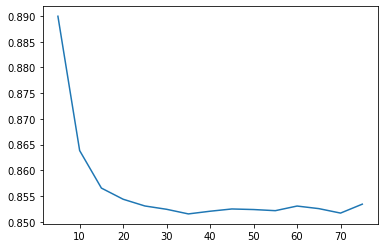

In [33]:
plt.plot(range(5, 80, 5), scores)

## Наилучший результат у модели KNNBaseline(k=35, sim_options={'name': 'pearson_baseline', 'user_based': False}). Резултат кросс-валидации -0.8515221682920865 